In [ ]:
#Libs
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.preprocessing import label_binarize

import gdown
import zipfile
import os
from sklearn.preprocessing import label_binarize


In [ ]:
!git clone https://github.com/Alkhatibnatasha/SOMEIP_IDS.git

Cloning into 'SOMEIP_IDS'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81 (from 1)
Receiving objects: 100% (81/81), 736.86 KiB | 7.29 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
!unzip /content/SOMEIP_IDS/Data/Sequence_data.zip -d /content/SOMEIP_IDS/Data/

Archive:  /content/SOMEIP_IDS/Data/Sequence_data.zip
  inflating: /content/SOMEIP_IDS/Data/X_test.pickle  
  inflating: /content/SOMEIP_IDS/Data/X_train.pickle  
  inflating: /content/SOMEIP_IDS/Data/Y_test.pickle  
  inflating: /content/SOMEIP_IDS/Data/Y_train.pickle  


Carregamento do dataset:

In [ ]:

# Caminho para os arquivos .pickle que foram extraídos
X_train_path = '/content/SOMEIP_IDS/Data/X_train.pickle'
Y_train_path = '/content/SOMEIP_IDS/Data/Y_train.pickle'
X_test_path = '/content/SOMEIP_IDS/Data/X_test.pickle'
Y_test_path = '/content/SOMEIP_IDS/Data/Y_test.pickle'

# Usando pd.read_pickle para carregar os arquivos
X_train = pd.read_pickle(X_train_path)
y_train = pd.read_pickle(Y_train_path)
X_test = pd.read_pickle(X_test_path)
y_test = pd.read_pickle(Y_test_path)

print("Dados carregados com sucesso!")
print("Formato de X_train:", X_train.shape)
print("Formato de y_train:", y_train.shape)
print("Formato de X_test:", X_test.shape)
print("Formato de y_test:", y_test.shape)


Dados carregados com sucesso!
Formato de X_train: (2807, 60, 195)
Formato de y_train: (2807, 1)
Formato de X_test: (2771, 60, 195)
Formato de y_test: (2771, 5)


In [ ]:
print(" DIAGNÓSTICO DAS VARIÁVEIS DE DADOS:")
try:
    print("\n--- DADOS DE TREINO ---")
    print(f"Tipo de X_train: {type(X_train)}")
    print(f"Formato (shape) de X_train: {X_train.shape}")
    print(f"Tipo de y_train: {type(y_train)}")
    print(f"Formato (shape) de y_train: {y_train.shape}")
    # Verifica o tipo de dados dentro do array, se for um numpy array
    if isinstance(y_train, np.ndarray):
      print(f"Tipo de dados (dtype) de y_train: {y_train.dtype}")
    print("Primeiros 5 rótulos de y_train:")
    print(y_train[:5])

    print("\n" + "="*40)

    print("\n--- DADOS DE TESTE ---")
    print(f"Tipo de X_test: {type(X_test)}")
    print(f"Formato (shape) de X_test: {X_test.shape}")
    print(f"Tipo de y_test: {type(y_test)}")
    print(f"Formato (shape) de y_test: {y_test.shape}")
    # Verifica o tipo de dados dentro do array, se for um numpy array
    if isinstance(y_test, np.ndarray):
      print(f"Tipo de dados (dtype) de y_test: {y_test.dtype}")
    print("Primeiros 5 rótulos de y_test:")
    print(y_test[:5])

except NameError:
    print("\nERRO: Uma ou mais variáveis (X_train, y_train, X_test, y_test) não foram encontradas.")
    print("Por favor, certifique-se de que a célula de carregamento dos dados .pickle foi executada com sucesso.")

 DIAGNÓSTICO DAS VARIÁVEIS DE DADOS:

--- DADOS DE TREINO ---
Tipo de X_train: <class 'numpy.ndarray'>
Formato (shape) de X_train: (2807, 60, 195)
Tipo de y_train: <class 'numpy.ndarray'>
Formato (shape) de y_train: (2807, 1)
Tipo de dados (dtype) de y_train: float64
Primeiros 5 rótulos de y_train:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


--- DADOS DE TESTE ---
Tipo de X_test: <class 'numpy.ndarray'>
Formato (shape) de X_test: (2771, 60, 195)
Tipo de y_test: <class 'numpy.ndarray'>
Formato (shape) de y_test: (2771, 5)
Tipo de dados (dtype) de y_test: float32
Primeiros 5 rótulos de y_test:
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


y_train tem a forma (2807, 1): Seus dados de treino são RÓTULOS DE INTEIROS (ex: 0, 1, 2, 3, 4).

y_test tem a forma (2771, 5): Seus dados de teste são RÓTULOS ONE-HOT ENCODED (ex: [0, 1, 0, 0, 0]).





## Normalização dos Rótulos
O primeiro e mais crítico passo é garantir que os rótulos de treino e de teste estejam no mesmo formato. O código abaixo inspeciona os rótulos e, independentemente de estarem no formato one-hot (ex: [0, 1, 0, 0, 0]) ou de inteiros com dimensão extra (ex: [1]), ele os converte para um formato padrão: um vetor 1D de inteiros (ex: [..., 0, 1, 4, 2, ...]).

In [ ]:
# Garante que os rótulos de treino sejam um vetor 1D de inteiros
if y_train.ndim == 2:
    if y_train.shape[1] == 5: # Se for one-hot (N, 5)
        print("y_train detectado como one-hot. Convertendo para inteiros...")
        y_train_norm = np.argmax(y_train, axis=1)
    else: # Se for (N, 1)
        print("y_train detectado com dimensão extra. Aplainando para 1D...")
        y_train_norm = y_train.flatten()
else:
    # Caso já seja 1D (N,)
    y_train_norm = y_train

# Garante que os rótulos de teste sejam um vetor 1D de inteiros
if y_test.ndim == 2:
    if y_test.shape[1] == 5: # Se for one-hot (N, 5)
        print("y_test detectado como one-hot. Convertendo para inteiros...")
        y_test_norm = np.argmax(y_test, axis=1)
    else: # Se for (N, 1)
        print("y_test detectado com dimensão extra. Aplainando para 1D...")
        y_test_norm = y_test.flatten()
else:
    # Caso já seja 1D (N,)
    y_test_norm = y_test

print("\nFormatos após a normalização:")
print(f"y_train_norm.shape: {y_train_norm.shape}")
print(f"y_test_norm.shape: {y_test_norm.shape}")



y_train detectado com dimensão extra. Aplainando para 1D...
y_test detectado como one-hot. Convertendo para inteiros...

Formatos após a normalização:
y_train_norm.shape: (2807,)
y_test_norm.shape: (2771,)


## Construção e Compilação do Modelo
Agora que garantimos que nossos rótulos são inteiros, podemos construir e compilar o modelo com a certeza da configuração correta. A arquitetura da rede RNN continua a mesma, mas o ponto crucial aqui é a escolha da função de perda: usaremos a `sparse_categorical_crossentropy`, que é a função exata para trabalhar com rótulos de classificação no formato de inteiros.

In [ ]:

def build_rnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        SimpleRNN(50, activation='tanh', return_sequences=True),
        SimpleRNN(10, activation='tanh'),
        Dense(5, activation='softmax') # 5 classes, saída em probabilidade
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# A forma da nossa feature é (60, 195)
model_input_shape = (X_train.shape[1], X_train.shape[2])
model = build_rnn_model(model_input_shape)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │        12,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10)             │           610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,965 (50.64 KB)

 Trainable params: 12,965 (50.64 KB)

 Non-trainable params: 0 (0.00 B)

## Treinamento do Modelo

Com os dados padronizados e o modelo compilado corretamente, a etapa final é o treinamento.

Na chamada model.fit, usaremos as variáveis normalizadas `y_train_norm` e `y_test_norm` que criamos no Passo 1. Os hiperparâmetros como *class_weights*, *epochs* e *batch_size* permanecem os mesmos.

In [ ]:
# Pesos de classe da Tabela III do artigo [1] para lidar com o desbalanceamento
class_weights = {
    0: 0.16,  # Normal
    1: 6.68,  # Error on Event
    2: 10.35, # Error on Error
    3: 4.33,  # Missing Response
    4: 4.86   # Missing Request
}

In [ ]:
# Hiperparâmetros de treinamento da Tabela V do artigo [1]
BATCH_SIZE = 100
EPOCHS = 50


In [ ]:
# Usando os rótulos normalizados y_train_norm e y_test_norm
history = model.fit(X_train, y_train_norm,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    validation_data=(X_test, y_test_norm),
                    verbose=1)

print("\nTreinamento concluído com sucesso!")

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.6065 - loss: 0.9625 - val_accuracy: 0.7055 - val_loss: 1.0274
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7717 - loss: 0.7119 - val_accuracy: 0.8575 - val_loss: 0.7285
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8982 - loss: 0.5814 - val_accuracy: 0.9177 - val_loss: 0.6536
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9253 - loss: 0.4367 - val_accuracy: 0.9051 - val_loss: 0.5426
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9494 - loss: 0.3097 - val_accuracy: 0.9477 - val_loss: 0.3430
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9756 - loss: 0.2184 - val_accuracy: 0.9589 - val_loss: 0.3189
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9751 - loss: 0.2194 - val_accuracy: 0.9740 - val_loss: 0.1941
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9865 - loss: 0.1513 - val_accuracy: 0.9711 - 

## Execução da Validação Cruzada

Em vez de um único treinamento, vamos treinar e validar o modelo 3 vezes para obter uma medida mais confiável de seu desempenho. Usamos a técnica StratifiedKFold para garantir que cada "dobra" (fold) da validação mantenha a proporção original de classes do seu dataset, o que é crucial para dados desbalanceados.

In [ ]:
model_input_shape = (X_train.shape[1], X_train.shape[2])
class_names = ['Normal', 'Error on Event', 'Error on Error', 'Missing Response', 'Missing Request']


In [ ]:
from sklearn.model_selection import StratifiedKFold


===== PROCESSANDO DOBRA (FOLD) 1/3 =====
Treinando na dobra 1...
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Dobra 1 concluída. Relatório de performance armazenado.

===== PROCESSANDO DOBRA (FOLD) 2/3 =====
Treinando na dobra 2...
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Dobra 2 concluída. Relatório de performance armazenado.

===== PROCESSANDO DOBRA (FOLD) 3/3 =====
Treinando na dobra 3...
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Dobra 3 concluída. Relatório de performance armazenado.


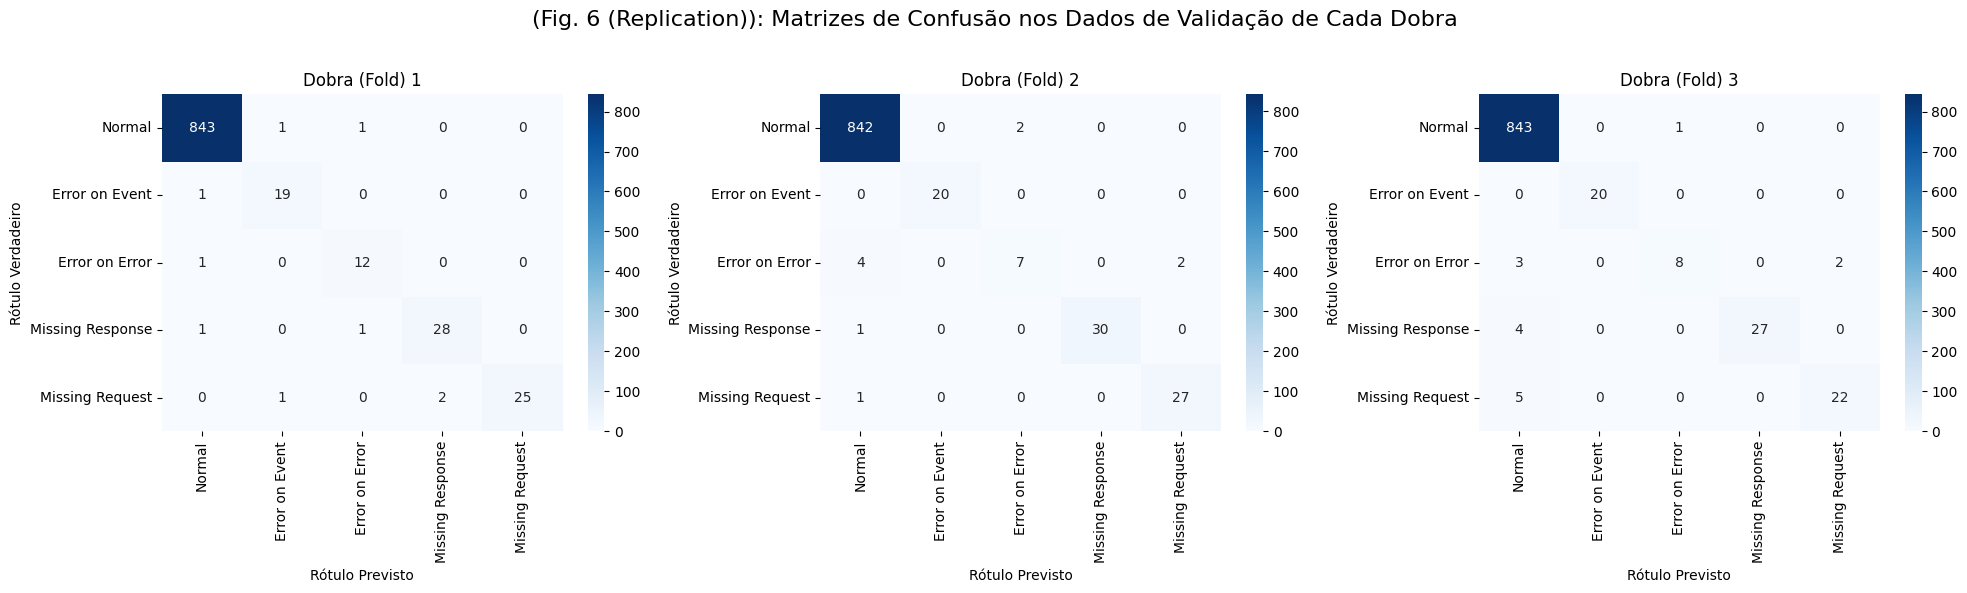

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_reports = [] # Lista para armazenar os relatórios de cada dobra
trained_models = [] #lista p armazenar os objetos do modelo

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('(Fig. 6 (Replication)): Matrizes de Confusão nos Dados de Validação de Cada Dobra', fontsize=16)


# Loop principal da validação cruzada
for i, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train_norm)):
    print(f"\n===== PROCESSANDO DOBRA (FOLD) {i+1}/3 =====")

    # Separa os dados de treino e validação para a dobra atual
    X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
    y_train_fold, y_val_fold = y_train_norm[train_indices], y_train_norm[val_indices]

    # Constrói um modelo novo e limpo a cada iteração
    model = build_rnn_model(model_input_shape)

    print(f"Treinando na dobra {i+1}...")
    # Nota: verbose=0 para um log de treinamento mais limpo durante o loop
    model.fit(X_train_fold, y_train_fold,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              class_weight=class_weights,
              validation_data=(X_val_fold, y_val_fold),
              verbose=0)
    # Gera previsões na porção de validação da dobra atual
    y_pred_fold = np.argmax(model.predict(X_val_fold), axis=1)

    cm = confusion_matrix(y_val_fold, y_pred_fold)
    ax = axes.flatten()[i]

    sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    ax.set_title(f'Dobra (Fold) {i+1}')
    ax.set_xlabel('Rótulo Previsto')
    ax.set_ylabel('Rótulo Verdadeiro')


    # Calcula e armazena o relatório detalhado como um dicionário
    report = classification_report(y_val_fold, y_pred_fold, target_names=class_names, output_dict=True)
    fold_reports.append(report)

    trained_models.append(model)

    print(f"Dobra {i+1} concluída. Relatório de performance armazenado.")


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Apresentação dos resultados

In [ ]:
print("\n\n" + "="*60)
print("         TABELA DE RESULTADOS DA VALIDAÇÃO")
print("="*60)

# Lista para guardar os dados formatados para a tabela
table_data = []

# Itera sobre os relatórios armazenados para extrair as métricas
for i, report in enumerate(fold_reports):
    fold_number = i + 1
    for class_name in class_names:
        metrics = report[class_name]
        table_data.append({
            "Fold": fold_number,
            "Class": class_name,
            "Recall": f"{metrics['recall']:.2f}",
            "Precision": f"{metrics['precision']:.2f}",
            "F1-Score": f"{metrics['f1-score']:.2f}"
        })

# Cria um DataFrame do Pandas para uma exibição elegante
results_df = pd.DataFrame(table_data)

# Exibe a tabela final formatada
print(results_df.to_string(index=False))



         TABELA DE RESULTADOS DA VALIDAÇÃO
 Fold            Class Recall Precision F1-Score
    1           Normal   1.00      1.00     1.00
    1   Error on Event   0.95      0.90     0.93
    1   Error on Error   0.92      0.86     0.89
    1 Missing Response   0.93      0.93     0.93
    1  Missing Request   0.89      1.00     0.94
    2           Normal   1.00      0.99     1.00
    2   Error on Event   1.00      1.00     1.00
    2   Error on Error   0.54      0.78     0.64
    2 Missing Response   0.97      1.00     0.98
    2  Missing Request   0.96      0.93     0.95
    3           Normal   1.00      0.99     0.99
    3   Error on Event   1.00      1.00     1.00
    3   Error on Error   0.62      0.89     0.73
    3 Missing Response   0.87      1.00     0.93
    3  Missing Request   0.81      0.92     0.86



--- Gerando Matrizes de Confusão para os Dados de Teste
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


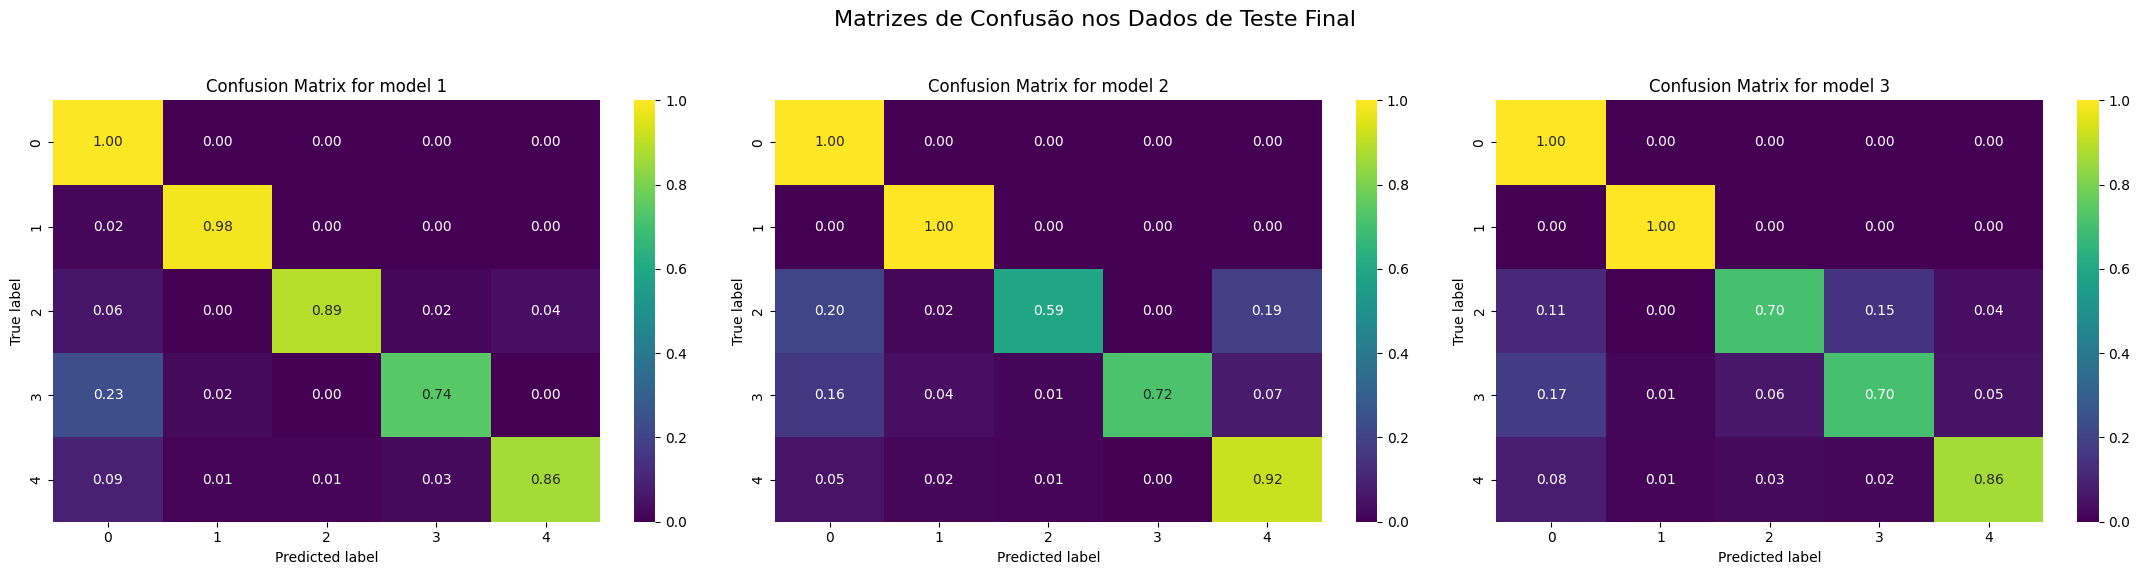

In [ ]:

print("\n--- Gerando Matrizes de Confusão para os Dados de Teste")

# Criar uma figura com 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Matrizes de Confusão nos Dados de Teste Final', fontsize=16)

# Iterar sobre cada um dos 3 modelos treinados na validação cruzada
for i, model in enumerate(trained_models):

    # Fazer as previsões no conjunto de teste final e intocado
    y_pred_test = np.argmax(model.predict(X_test), axis=1)

    # Os rótulos verdadeiros são sempre os mesmos (y_test_norm)
    y_true_test = y_test_norm

    # Calcular a matriz de confusão normalizada
    cm = confusion_matrix(y_true_test, y_pred_test, normalize='true')

    # Plotar o heatmap no subplot correspondente
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='viridis', ax=axes[i], vmin=0, vmax=1)
    axes[i].set_title(f'Confusion Matrix for model {i+1}')
    axes[i].set_xlabel('Predicted label')
    axes[i].set_ylabel('True label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout
plt.show()

--- Geração de Curvas ROC e AUC para os Dados de Validação ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


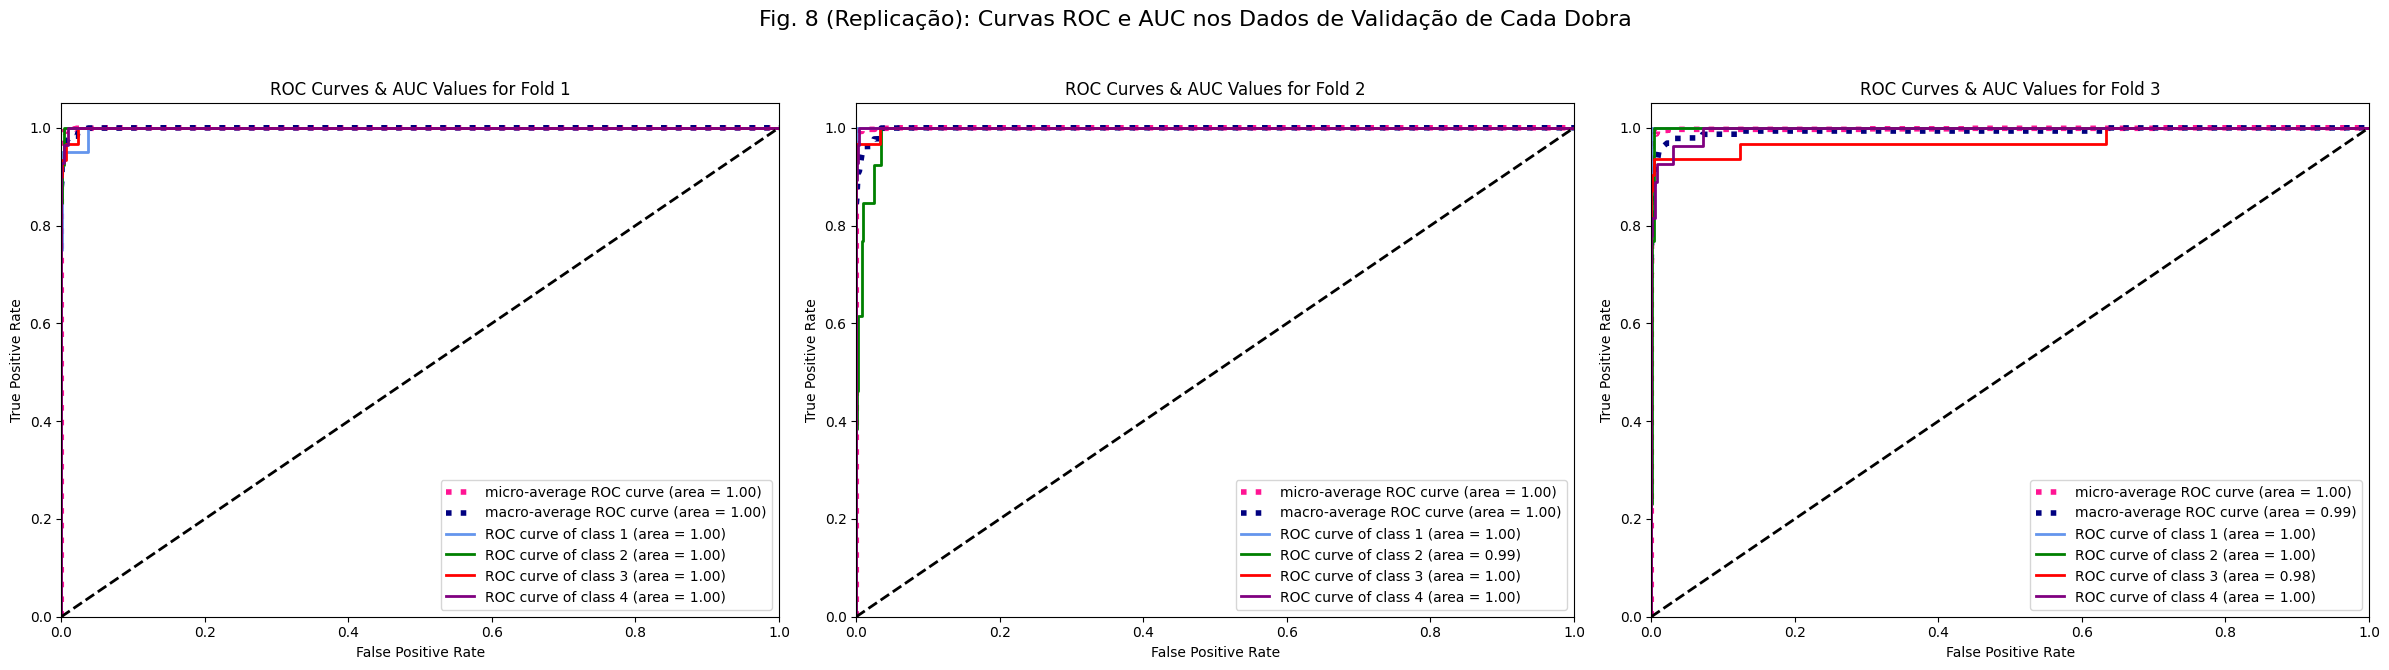

In [ ]:

#GERAÇÃO DAS CURVAS ROC





print("--- Geração de Curvas ROC e AUC para os Dados de Validação ---")

# Parâmetros
n_classes = len(class_names)

# Recriar as dobras para garantir o acesso aos dados de validação corretos
kfold_fig8 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Criar uma figura com 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Fig. 8 (Replicação): Curvas ROC e AUC nos Dados de Validação de Cada Dobra', fontsize=16)

# Iterar sobre as dobras e os modelos treinados
for i, (train_indices, val_indices) in enumerate(kfold_fig8.split(X_train, y_train_norm)):
    # Pegar o modelo e os dados de validação para esta dobra
    model_fold = trained_models[i]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train_norm[val_indices]

    # Binarizar os rótulos de validação para análise multi-classe
    y_val_binarized = label_binarize(y_val_fold, classes=list(range(n_classes)))

    # Obter as probabilidades previstas pelo modelo
    y_pred_proba = model_fold.predict(X_val_fold)

    # Dicionários para armazenar as taxas de Falsos e Verdadeiros Positivos e a área AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcular a curva ROC para cada classe
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_val_binarized[:, j], y_pred_proba[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Calcular a curva ROC micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calcular a curva ROC macro-average CORRETAMENTE
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):

        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plotar todas as curvas no subplot correspondente
    ax = axes[i]
    ax.plot(fpr["micro"], tpr["micro"],
            label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
            color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['darkorange', 'cornflowerblue', 'green', 'red', 'purple']) # Cores para as classes
    for j, color in zip(range(n_classes), colors):
        # Não plotar a curva para a classe 'Normal' (classe 0) para evitar poluição visual, como feita no artigo base [1]
        if j > 0:
            ax.plot(fpr[j], tpr[j], color=color, lw=2,
                    label=f'ROC curve of class {j} (area = {roc_auc[j]:0.2f})')

    # Linha de referência (chance)
    ax.plot([0, 1], [0, 1], 'k--', lw=2)

    # Configurações do gráfico
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves & AUC Values for Fold {i+1}')
    ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Célula para gerar e exibir os relatórios de classificação para o conjunto de teste

test_reports = []
for i, model in enumerate(trained_models):
    print(f"\n AVALIANDO MODELO na dobra {i+1} NOS DADOS DE TESTE FINAL")
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    y_true_test = y_test_norm

    report = classification_report(y_true_test, y_pred_test, target_names=class_names, output_dict=True)
    test_reports.append(report)

    print(f"\n Relatório de Classificação do Modelo {i+1} no Conjunto de Teste: ")
    print(classification_report(y_true_test, y_pred_test, target_names=class_names))
    print("="*65)


 AVALIANDO MODELO na dobra 1 NOS DADOS DE TESTE FINAL
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

 Relatório de Classificação do Modelo 1 no Conjunto de Teste: 
                  precision    recall  f1-score   support

          Normal       0.99      1.00      0.99      2471
  Error on Event       0.91      0.98      0.95        54
  Error on Error       0.87      0.89      0.88        54
Missing Response       0.92      0.74      0.82        81
 Missing Request       0.96      0.86      0.91       111

        accuracy                           0.98      2771
       macro avg       0.93      0.89      0.91      2771
    weighted avg       0.98      0.98      0.98      2771


 AVALIANDO MODELO na dobra 2 NOS DADOS DE TESTE FINAL
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

 Relatório de Classificação do Modelo 2 no Conjunto de Teste: 
                  precision    recall  f1-score   support

          Normal       0.99      1.00      0.99      2471
  Error on Event       0.86      1.00   

Gerando Curvas ROC e AUC para cada Modelo no Conjunto de TESTE: 
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


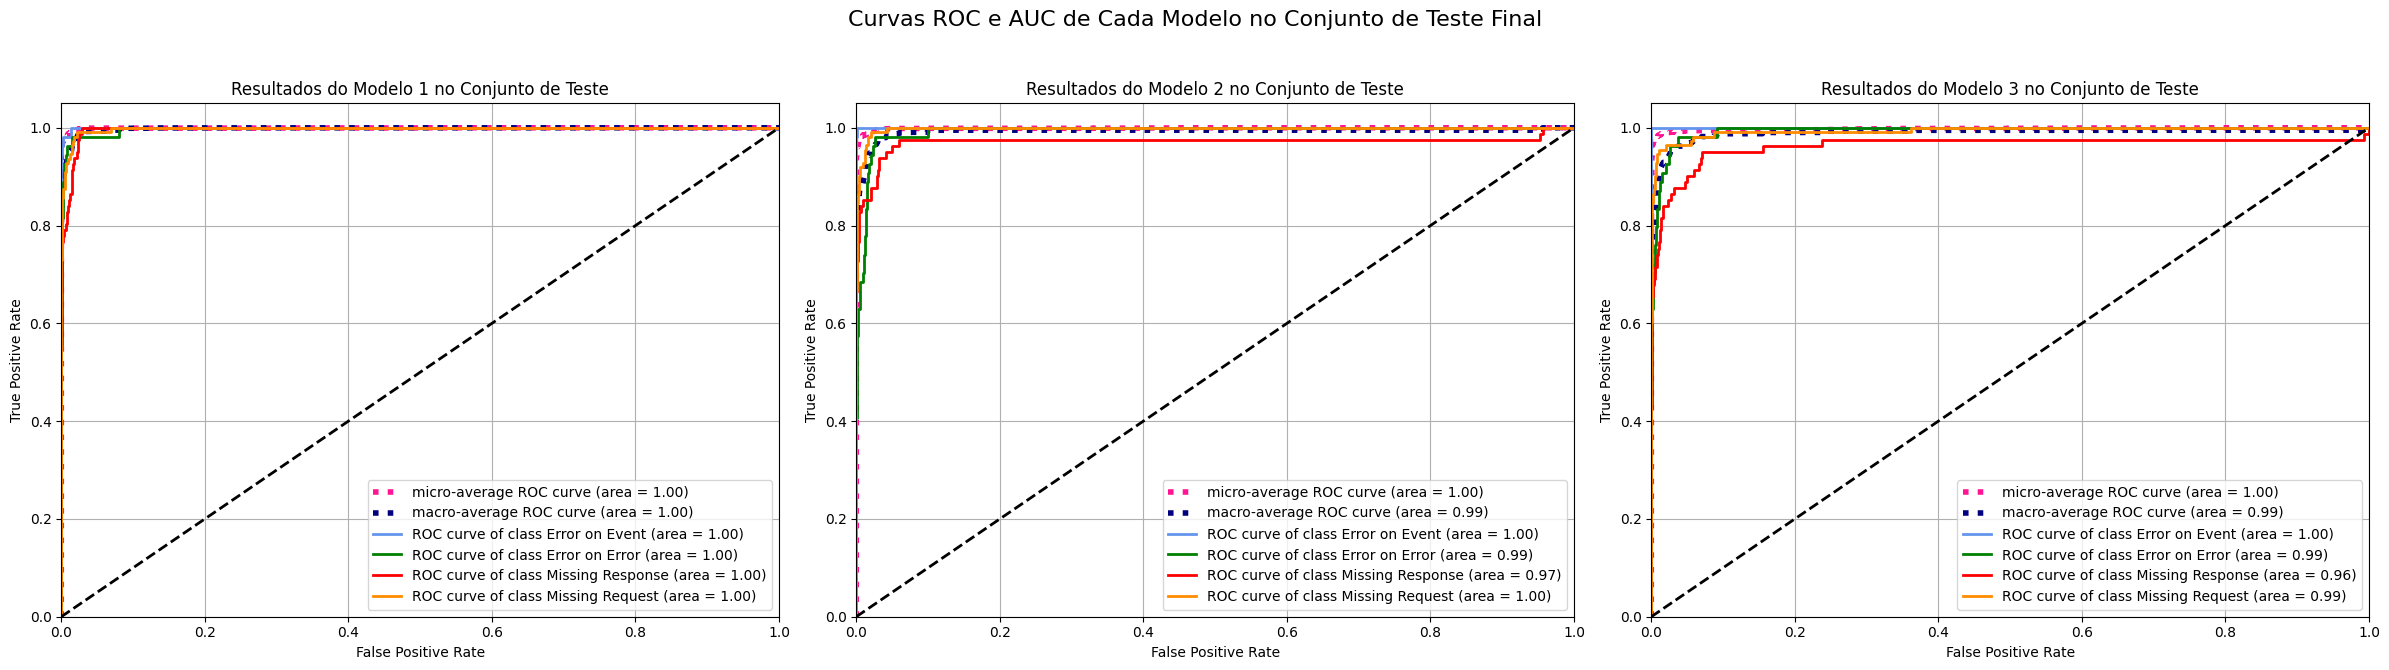

In [ ]:
print("Gerando Curvas ROC e AUC para cada Modelo no Conjunto de TESTE: ")

# Parâmetros
n_classes = len(class_names)

# Binarizar os rótulos do CONJUNTO DE TESTE uma única vez, pois serão os mesmos para cada modelo
y_test_binarized = label_binarize(y_test_norm, classes=list(range(n_classes)))

# Criar uma figura com 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Curvas ROC e AUC de Cada Modelo no Conjunto de Teste Final', fontsize=16)

# Iterar sobre os 3 modelos treinados
for i, model_fold in enumerate(trained_models):

    # Obter as probabilidades previstas pelo modelo ATUAL no conjunto de TESTE
    y_pred_proba = model_fold.predict(X_test)

    # Dicionários para armazenar as taxas e a área AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcular a curva ROC para cada classe
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_binarized[:, j], y_pred_proba[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Calcular a curva ROC micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calcular a curva ROC macro-average
    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plotar todas as curvas no subplot correspondente
    ax = axes[i]
    ax.plot(fpr["micro"], tpr["micro"],
            label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
            color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['darkorange', 'cornflowerblue', 'green', 'red'])
    for j, color in zip(range(n_classes), colors):
        if j > 0: # Mesma lógica para não plotar a classe 'Normal'
            ax.plot(fpr[j], tpr[j], color=color, lw=2,
                    label=f'ROC curve of class {class_names[j]} (area = {roc_auc[j]:.2f})')

    # Linha de referência
    ax.plot([0, 1], [0, 1], 'k--', lw=2)

    # Configurações do gráfico
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Resultados do Modelo {i+1} no Conjunto de Teste')
    ax.legend(loc="lower right")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("roc_curves_all_models_on_test_set.png")
plt.show()


#### Aplicação com TUNAGEM

#Aplicação  do modelo reconstruído em uma nova base de dados

**Artigo de referência:** [2] *Qi Liu, Xingyu Li, Ke Sun, Yufeng Li, and Yanchen Liu. SISSA: Real-
time Monitoring of Hardware Functional Safety and Cybersecurity with
In-vehicle SOME/IP Ethernet Traffic. arXiv preprint arXiv:2401.03309,
2024*

In [ ]:
!rm -rf my_tuner_dir
!rm -rf tuner_results

## 1. Carregamento de dados

In [ ]:
!pip install -q gdown


In [ ]:
file_id = '1-pl9OOFcTZCuPLRzusjlmkMn7Q-f-0fU'
output_file = 'data.7z'

In [ ]:
print(f"Baixando o arquivo com ID: {file_id}...")
gdown.download(id=file_id, output=output_file, quiet=False)


Baixando o arquivo com ID: 1-pl9OOFcTZCuPLRzusjlmkMn7Q-f-0fU...


Downloading...
From: https://drive.google.com/uc?id=1-pl9OOFcTZCuPLRzusjlmkMn7Q-f-0fU
To: /content/data.7z
100%|██████████| 24.4M/24.4M [00:00<00:00, 68.0MB/s]


'data.7z'

In [ ]:
print("\nDescompactando o arquivo 'data.7z'...")
!7z x data.7z
print("Descompactação concluída!")


Descompactando o arquivo 'data.7z'...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 24442938 bytes (24 MiB)

Extracting archive: data.7z
--
Path = data.7z
Type = 7z
Physical Size = 24442938
Headers Size = 407
Method = LZMA2:24
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./data/processed/_0.npy
  Size:     32934528 bytes (32 MiB)
  Modified: 2023-12-19 05:33:33
with the file from archive:
  Path:     data/processed/_0.npy
  Size:     32934528 bytes (32 MiB)
  Modified: 2023-12-19 05:33:33
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? y

  0% 5 - data/processed/_0.npy                              
Would you like to replace the ex

In [ ]:
print("\nConteúdo do diretório atual:")
!ls -l

# Verifica o conteúdo DENTRO da pasta 'data'
print("\nConteúdo da pasta 'data/':")
!ls -l data/


Conteúdo do diretório atual:
total 24004
drwx------ 6 root root     4096 Feb  1  2024 data
-rw-r--r-- 1 root root 24442938 Feb  1  2024 data.7z
-rw-r--r-- 1 root root   118973 Aug 12 00:32 roc_curves_all_models_on_test_set.png
drwxr-xr-x 1 root root     4096 Aug  8 20:22 sample_data
drwxr-xr-x 6 root root     4096 Aug 11 21:58 SOMEIP_IDS

Conteúdo da pasta 'data/':
total 16
drwx------ 2 root root 4096 Feb  1  2024 processed
drwx------ 2 root root 4096 Feb  1  2024 raw
drwx------ 2 root root 4096 Feb  1  2024 train
drwx------ 2 root root 4096 Feb  1  2024 val


In [ ]:
# --- Carregar os dados de treino e validação ---
train_data_path = 'data/train/data.npy'
train_labels_path = 'data/train/labels.npy'
val_data_path = 'data/val/data.npy'
val_labels_path = 'data/val/labels.npy'

# Carregar os arrays NumPy
X_train = np.load(train_data_path)
y_train = np.load(train_labels_path)
X_val = np.load(val_data_path)
y_val = np.load(val_labels_path)



# --- Diagnóstico dos Dados Carregados ---
print("--- DADOS DE TREINO ---")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
print("\n--- DADOS DE VALIDAÇÃO (TESTE) ---")
print(f"Formato de X_val: {X_val.shape}")
print(f"Formato de y_val: {y_val.shape}")

# O artigo SISSA menciona 7 classes. Define-se as classes:
class_names = [
    'Normal',
    'DDoS',
    'Fake Interface',
    'Fake Source',
    'ReqNoRes',
    'ResNoReq',
    'Hardware Failure'
]
n_classes = len(class_names)

--- DADOS DE TREINO ---
Formato de X_train: (14406, 128, 25)
Formato de y_train: (14406,)

--- DADOS DE VALIDAÇÃO (TESTE) ---
Formato de X_val: (3605, 128, 25)
Formato de y_val: (3605,)


## 2. Pré processamento


In [ ]:
# Juntar os dados de treino e validação em um único conjunto de dados completo
X_full = np.concatenate((X_train, X_val), axis=0)
y_full = np.concatenate((y_train, y_val), axis=0)

In [ ]:
print("--- Dados Unificados para Validação Cruzada ---")
print(f"Formato do dataset completo (X_full): {X_full.shape}")
print(f"Formato dos rótulos completos (y_full): {y_full.shape}")


--- Dados Unificados para Validação Cruzada ---
Formato do dataset completo (X_full): (18011, 128, 25)
Formato dos rótulos completos (y_full): (18011,)


In [ ]:
# Conta a ocorrência de cada classe no seu conjunto de dados completo
unique_classes, counts = np.unique(y_full, return_counts=True)

balance_df = pd.DataFrame({
    'Classe': [class_names[i] for i in unique_classes],
    'Amostras': counts
})
print("--- Verificação de Balanceamento do Dataset ---")
print(balance_df)

--- Verificação de Balanceamento do Dataset ---
             Classe  Amostras
0            Normal      2573
1              DDoS      2573
2    Fake Interface      2573
3       Fake Source      2573
4          ReqNoRes      2573
5          ResNoReq      2573
6  Hardware Failure      2573


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

In [ ]:
print(f"Formato do Conjunto de Desenvolvimento (para Tunagem/CV): {X_dev.shape}")
print(f"Formato do Conjunto de Teste Final (intocado): {X_test.shape}")

Formato do Conjunto de Desenvolvimento (para Tunagem/CV): (14408, 128, 25)
Formato do Conjunto de Teste Final (intocado): (3603, 128, 25)


In [ ]:
import gc
del X_train, y_train, X_val, y_val
gc.collect()

11

## 2. Tunagem dos Hiperparâmetros

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
def model_builder_for_tuning(hp):
    # Definindo a faixa de valores (espaço de busca) para testar
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Construindo o modelo com os valores que o tuner vai testar
    model = Sequential([
        Input(shape=(X_full.shape[1], X_full.shape[2])),
        SimpleRNN(hp_units_1, activation='tanh', return_sequences=True),
        SimpleRNN(hp_units_2, activation='tanh'),
        Dense(n_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
#Divisão simples dos dados apenas para a fase de tunagem
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=42, stratify=y_dev
)


In [ ]:
# Configuração e execução do tuner
tuner = kt.RandomSearch(
    model_builder_for_tuning,
    objective='val_accuracy',
    max_trials=10, # Testará 10 combinações de modelos
    directory='tuner_results',
    project_name='sissa_rnn_tuning'
)


In [ ]:
print("\n--- Iniciando a Busca por Hiperparâmetros (PROCESSO DEMORADO) ---")
tuner.search(X_train_tune, y_train_tune, epochs=10, validation_data=(X_val_tune, y_val_tune))

#Obtenção dos melhores parâmetros encontrados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 10 Complete [00h 03m 52s]
val_accuracy: 0.2751561403274536

Best val_accuracy So Far: 0.6242192983627319
Total elapsed time: 00h 50m 51s


In [ ]:
print(f"""
--- Busca Concluída ---
A melhor combinação de hiperparâmetros encontrada foi:
- Neurônios Camada 1: {best_hps.get('units_1')}
- Neurônios Camada 2: {best_hps.get('units_2')}
- Taxa de Aprendizado: {best_hps.get('learning_rate')}
""")


--- Busca Concluída ---
A melhor combinação de hiperparâmetros encontrada foi:
- Neurônios Camada 1: 96
- Neurônios Camada 2: 32
- Taxa de Aprendizado: 0.001



## 4. Construção do Modelo para Executar a Validação Cruzada

Precisamos agora dizer a função `build_rnn_model` que agora ela deve criar uma saída para 7 classes, e não 5 como antes.

In [ ]:
# Hiperparâmetros de treinamento
BATCH_SIZE = 100
EPOCHS = 50
N_SPLITS = 3
N_CLASSES = 7

# Configuração da Validação Cruzada
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_reports = []
trained_models = []

### MODELO COM TUNAGEM

In [ ]:
## CODIGO COM TUNAGEM DA CONSTRUCAO DO MODELO
def build_best_rnn_model(input_shape, num_classes, hyperparameters):
    """
    Constrói o modelo RNN usando um conjunto específico de hiperparâmetros.
    """
    model = Sequential([
        Input(shape=input_shape),
        # Usamos os valores do objeto 'hyperparameters' em vez de números fixos
        SimpleRNN(hyperparameters.get('units_1'), activation='tanh', return_sequences=True),
        SimpleRNN(hyperparameters.get('units_2'), activation='tanh'),
        Dense(num_classes, activation='softmax')
    ])

    # Usamos a taxa de aprendizado encontrada pelo tuner
    optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters.get('learning_rate'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


#### VALIDACAO CRUZADA COM TUNAGEM

In [ ]:
# Listas para armazenar os resultados
fold_reports = []
trained_models = []


===== PROCESSANDO DOBRA (FOLD) 1/3 =====
Treinando na dobra 1...
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Dobra 1: Avaliação concluída.

===== PROCESSANDO DOBRA (FOLD) 2/3 =====
Treinando na dobra 2...
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Dobra 2: Avaliação concluída.

===== PROCESSANDO DOBRA (FOLD) 3/3 =====
Treinando na dobra 3...
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Dobra 3: Avaliação concluída.


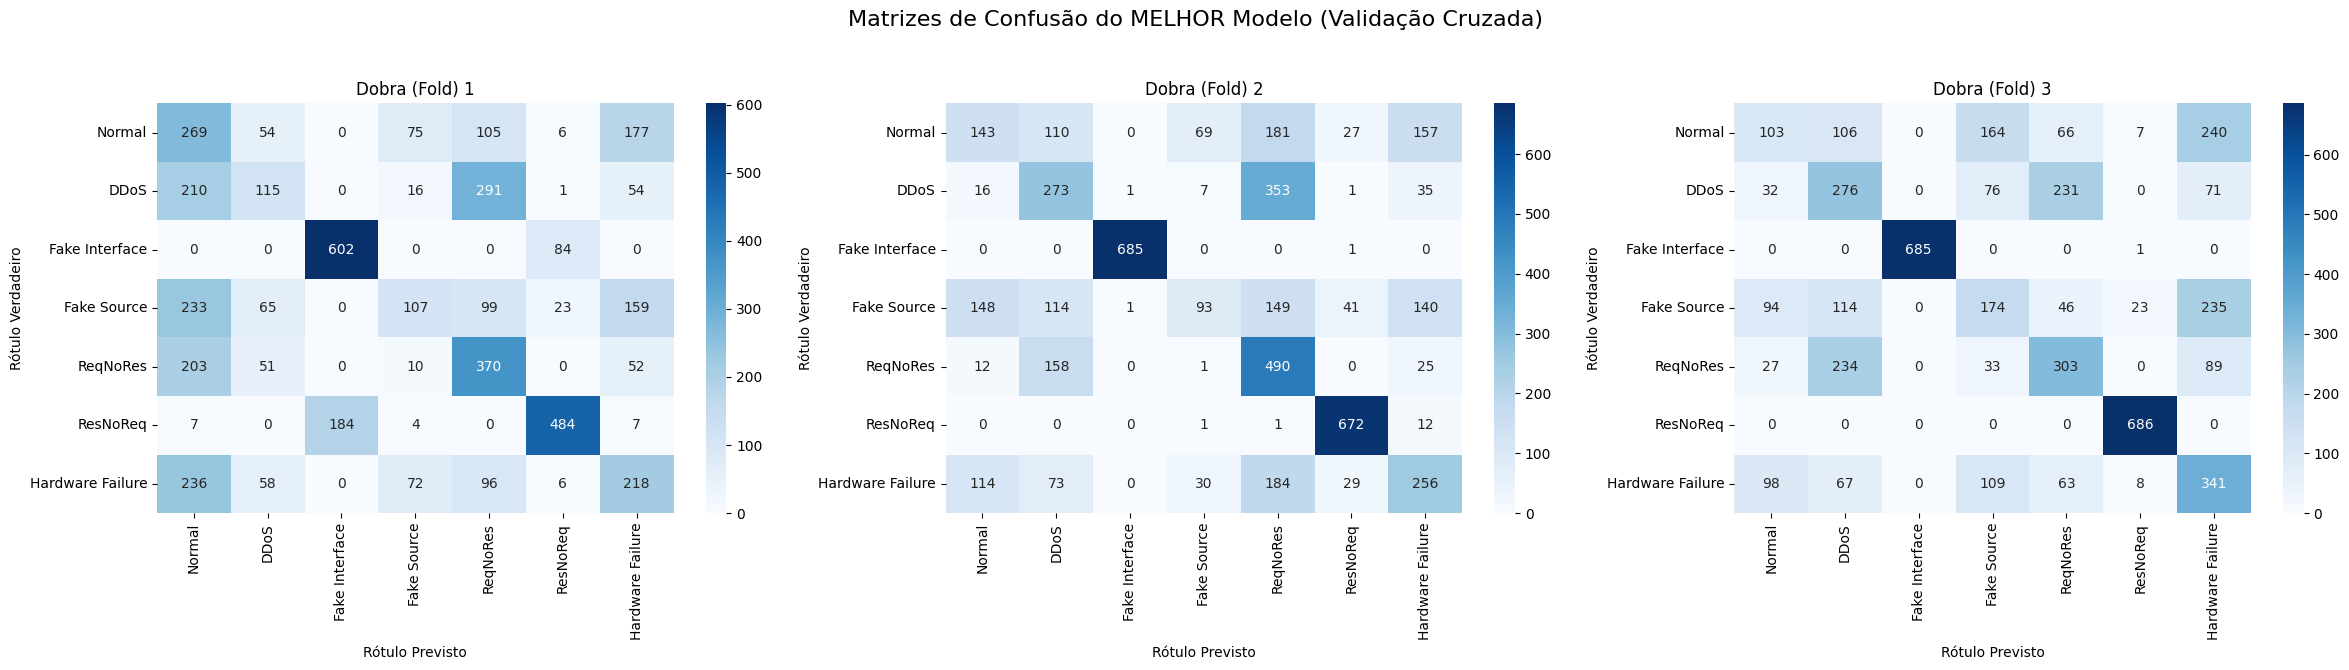

In [ ]:

# Preparação para plotar as matrizes de confusão
fig, axes = plt.subplots(1, N_SPLITS, figsize=(24, 7))
fig.suptitle('Matrizes de Confusão do MELHOR Modelo (Validação Cruzada)', fontsize=16)


# Loop principal da validação cruzada
for fold, (train_indices, val_indices) in enumerate(kfold.split(X_dev, y_dev)):
    print(f"\n===== PROCESSANDO DOBRA (FOLD) {fold + 1}/{N_SPLITS} =====")

    # Separa os dados da dobra
    X_train_fold, X_val_fold = X_dev[train_indices], X_dev[val_indices]
    y_train_fold, y_val_fold = y_dev[train_indices], y_dev[val_indices]

    # Constrói um modelo novo a cada iteração, mas sempre usando a MELHOR RECEITA (best_hps)
    model_input_shape = (X_train_fold.shape[1], X_train_fold.shape[2])
    model_fold = build_best_rnn_model(model_input_shape, num_classes=N_CLASSES, hyperparameters=best_hps)
    # --- FIM DA MUDANÇA ---

    print(f"Treinando na dobra {fold + 1}...")
    model_fold.fit(X_train_fold, y_train_fold,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=(X_val_fold, y_val_fold),
                   verbose=0)

    # Armazena o modelo treinado
    trained_models.append(model_fold)

    # Gera previsões, matriz de confusão e relatório...
    y_pred_fold = np.argmax(model_fold.predict(X_val_fold), axis=1)
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    ax = axes.flatten()[fold]
    sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'Dobra (Fold) {fold + 1}')
    ax.set_xlabel('Rótulo Previsto')
    ax.set_ylabel('Rótulo Verdadeiro')

    report = classification_report(y_val_fold, y_pred_fold, target_names=class_names, output_dict=True)
    fold_reports.append(report)
    print(f"Dobra {fold + 1}: Avaliação concluída.")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 4.1 RESULTADOS

In [ ]:
print("\n" + "="*65)
print("     TABELA DE RESULTADOS DA VALIDAÇÃO C TUNAGEM (Estilo Tabela IV do Artigo)")
print("="*65)

table_data = []
for i, report in enumerate(fold_reports):
    fold_number = i + 1
    for class_name in class_names:
        metrics = report[class_name]
        table_data.append({
            "Fold": fold_number,
            "Class": class_name,
            "Recall": f"{metrics['recall']:.2f}",
            "Precision": f"{metrics['precision']:.2f}",
            "F1-Score": f"{metrics['f1-score']:.2f}"
        })

results_df = pd.DataFrame(table_data)
print(results_df.to_string(index=False))


     TABELA DE RESULTADOS DA VALIDAÇÃO C TUNAGEM (Estilo Tabela IV do Artigo)
 Fold            Class Recall Precision F1-Score
    1           Normal   0.39      0.23     0.29
    1             DDoS   0.17      0.34     0.22
    1   Fake Interface   0.88      0.77     0.82
    1      Fake Source   0.16      0.38     0.22
    1         ReqNoRes   0.54      0.39     0.45
    1         ResNoReq   0.71      0.80     0.75
    1 Hardware Failure   0.32      0.33     0.32
    2           Normal   0.21      0.33     0.26
    2             DDoS   0.40      0.38     0.39
    2   Fake Interface   1.00      1.00     1.00
    2      Fake Source   0.14      0.46     0.21
    2         ReqNoRes   0.71      0.36     0.48
    2         ResNoReq   0.98      0.87     0.92
    2 Hardware Failure   0.37      0.41     0.39
    3           Normal   0.15      0.29     0.20
    3             DDoS   0.40      0.35     0.37
    3   Fake Interface   1.00      1.00     1.00
    3      Fake Source   0.25      0.31


 Gerando Curvas ROC e AUC para os Dados de Validação: 
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


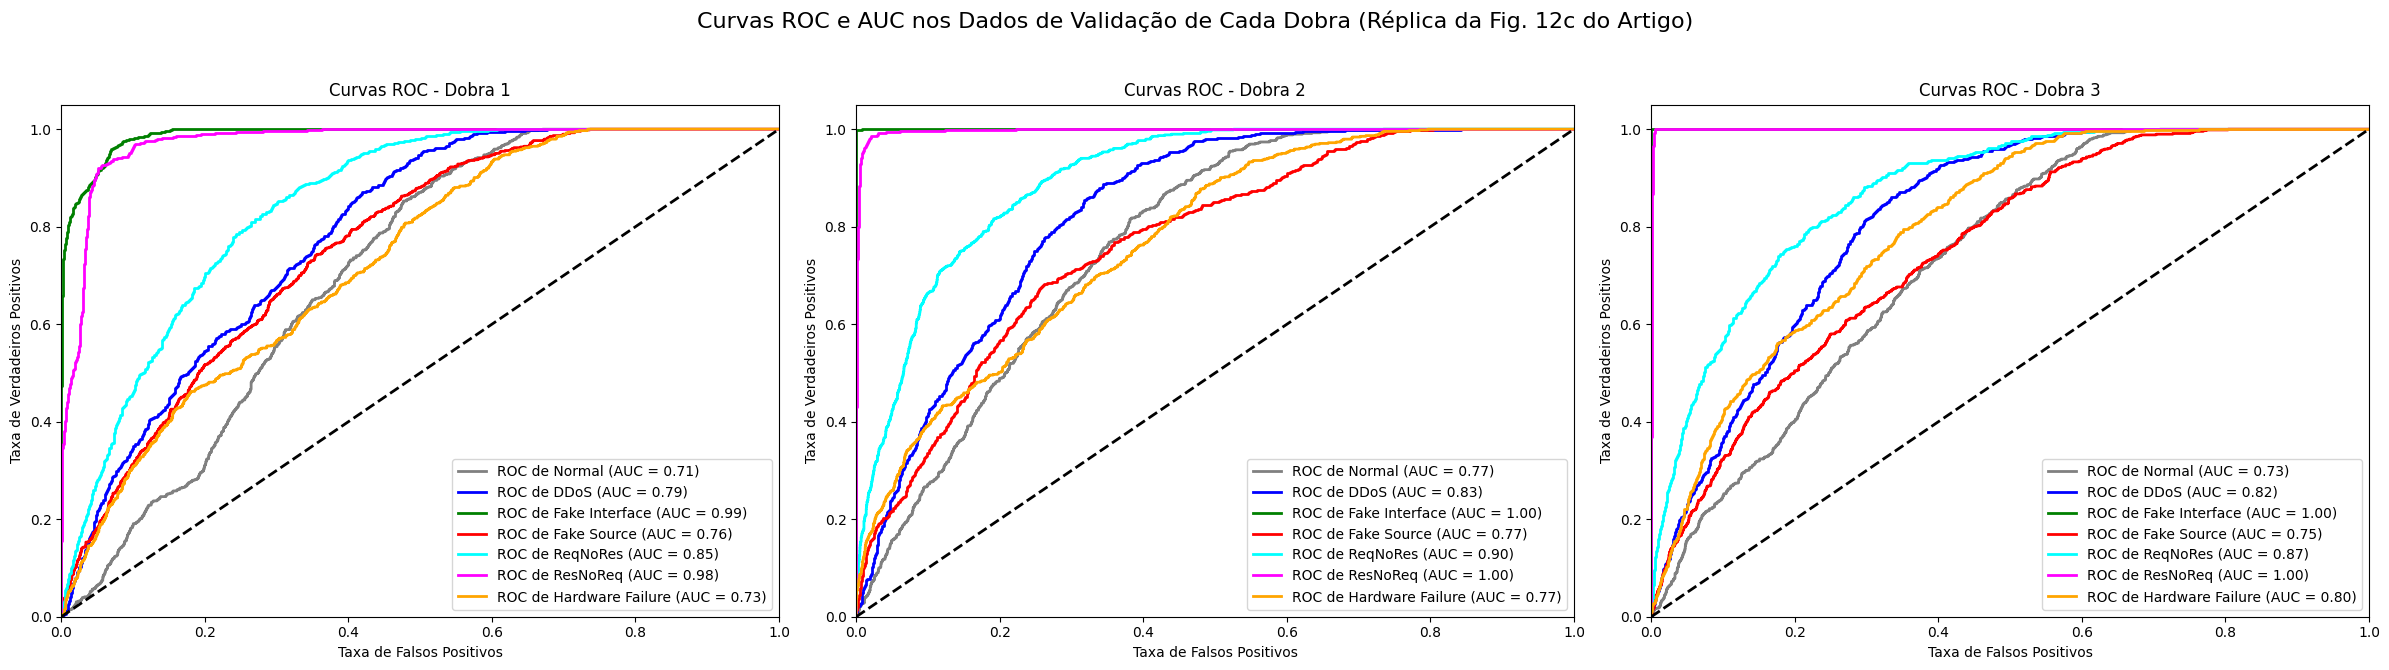

In [ ]:
print("\n Gerando Curvas ROC e AUC para os Dados de Validação: ")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Curvas ROC e AUC nos Dados de Validação de Cada Dobra (Réplica da Fig. 12c do Artigo)', fontsize=16)

# Recria as dobras para garantir a consistência
kfold_roc = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for i, (train_indices, val_indices) in enumerate(kfold_roc.split(X_dev, y_dev)):
    model_fold = trained_models[i]
    X_val_fold = X_dev[val_indices]
    y_val_fold = y_dev[val_indices]

    # Binariza os rótulos para análise multi-classe
    y_val_binarized = label_binarize(y_val_fold, classes=list(range(n_classes)))
    y_pred_proba = model_fold.predict(X_val_fold)

    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Calcula a curva ROC para cada classe
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_val_binarized[:, j], y_pred_proba[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Calcula a curva ROC micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plota as curvas no subplot
    ax = axes[i]
    colors = cycle(['gray', 'blue', 'green', 'red', 'cyan', 'magenta', 'orange'])
    for j, color in zip(range(n_classes), colors):
        ax.plot(fpr[j], tpr[j], color=color, lw=2,
                label=f'ROC de {class_names[j]} (AUC = {roc_auc[j]:0.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taxa de Falsos Positivos')
    ax.set_ylabel('Taxa de Verdadeiros Positivos')
    ax.set_title(f'Curvas ROC - Dobra {i+1}')
    ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Teste com modelo criado a partir da tunagem


In [ ]:
for i, model_fold in enumerate(trained_models):
    print(f"===== Análise do Modelo Treinado na Dobra (Fold) {i+1} =====")

    # Gera previsões de probabilidade no conjunto de teste
    y_pred_proba = model_fold.predict(X_test)

    # Converte as probabilidades para a classe com maior valor
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # Exibe o relatório de classificação completo
    print(classification_report(y_test, y_pred_classes, target_names=class_names))
    print("-" * 60 + "\n")


===== Análise do Modelo Treinado na Dobra (Fold) 1 =====
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
                  precision    recall  f1-score   support

          Normal       0.22      0.35      0.27       514
            DDoS       0.36      0.22      0.27       514
  Fake Interface       0.76      0.90      0.82       515
     Fake Source       0.36      0.16      0.22       515
        ReqNoRes       0.41      0.56      0.47       515
        ResNoReq       0.78      0.69      0.73       515
Hardware Failure       0.35      0.32      0.34       515

        accuracy                           0.46      3603
       macro avg       0.46      0.46      0.45      3603
    weighted avg       0.46      0.46      0.45      3603

------------------------------------------------------------

===== Análise do Modelo Treinado na Dobra (Fold) 2 =====
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
                  precision    recall  f1-score   support

          Normal       0.36      0.25   

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


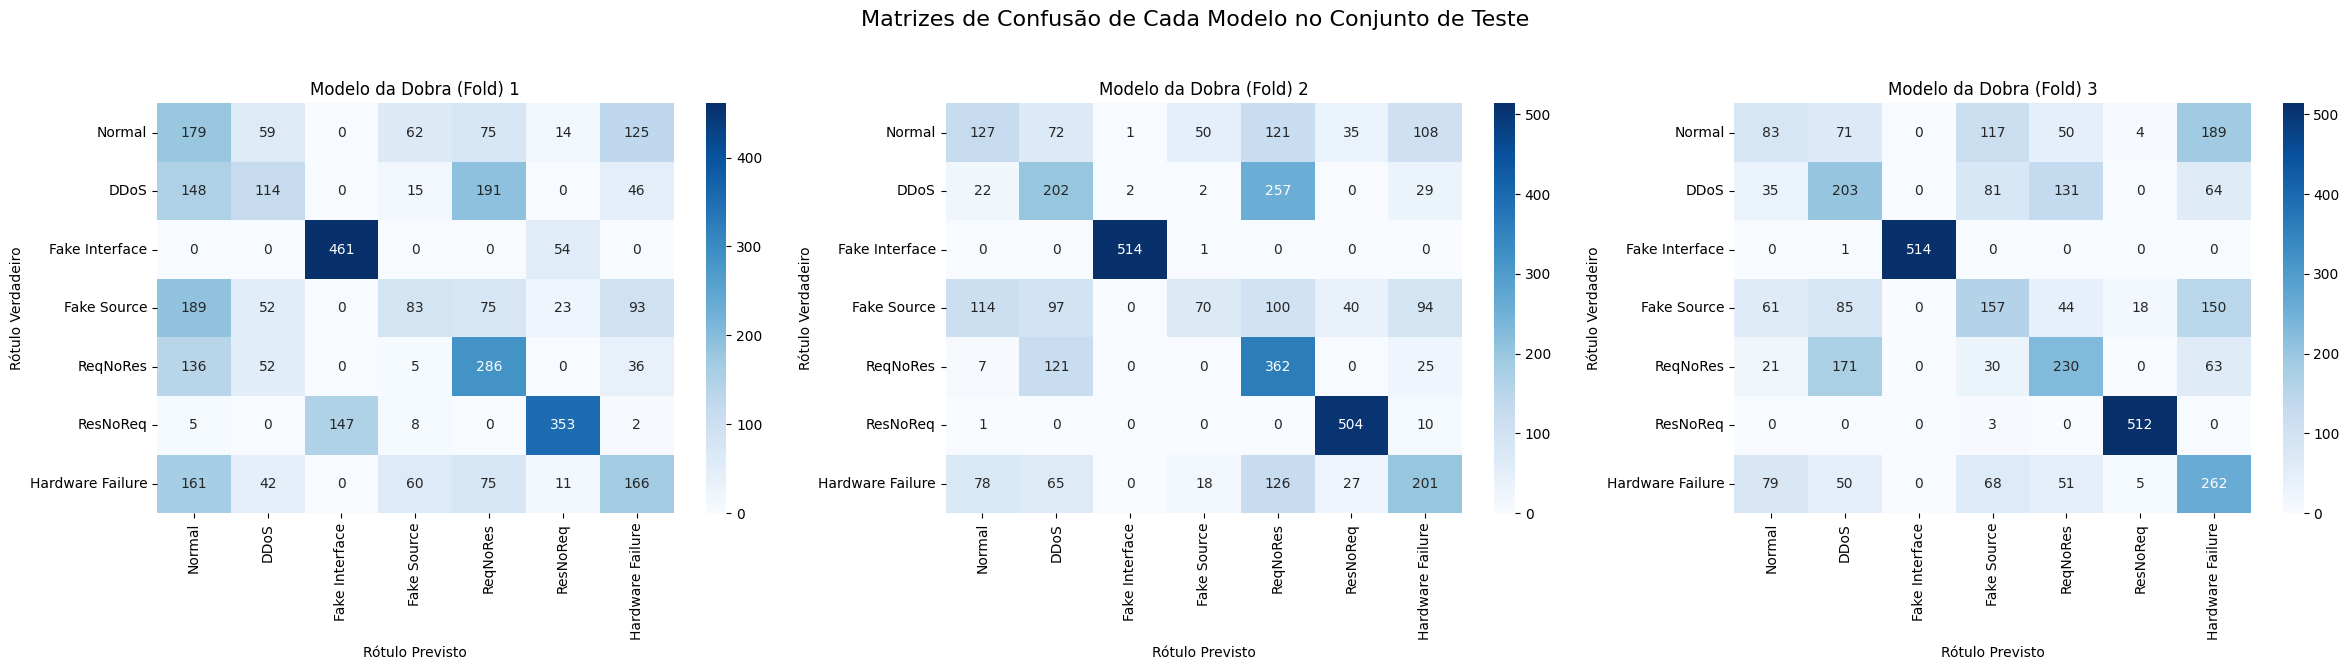

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Matrizes de Confusão de Cada Modelo no Conjunto de Teste', fontsize=16)

for i, model_fold in enumerate(trained_models):
    # Gera as previsões
    y_pred_classes = np.argmax(model_fold.predict(X_test), axis=1)

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plota no subplot correto
    ax = axes[i]
    sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'Modelo da Dobra (Fold) {i+1}')
    ax.set_xlabel('Rótulo Previsto')
    ax.set_ylabel('Rótulo Verdadeiro')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


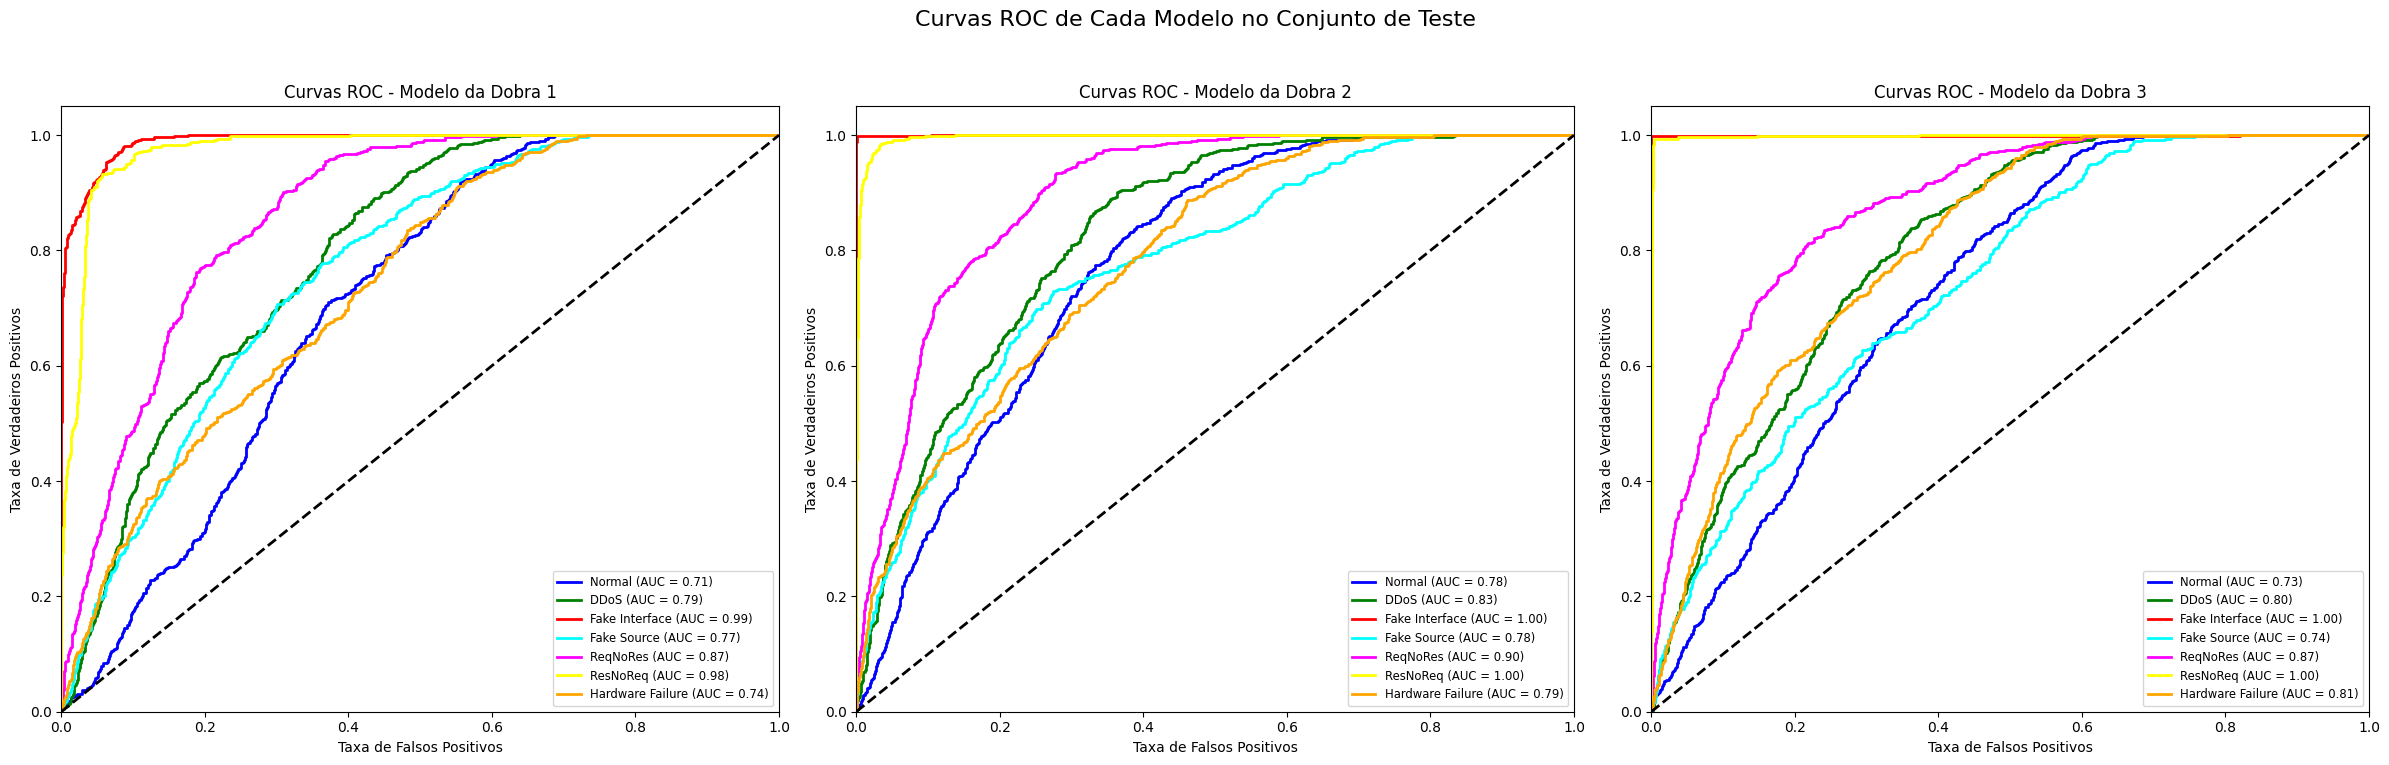

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Curvas ROC de Cada Modelo no Conjunto de Teste', fontsize=16)
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange'])

for i, model_fold in enumerate(trained_models):
    ax = axes[i]

    # Binariza os rótulos verdadeiros do conjunto de teste
    y_test_binarized = label_binarize(y_test, classes=range(n_classes))

    # Gera as previsões de probabilidade no conjunto de teste
    y_pred_proba = model_fold.predict(X_test)

    # Calcula e plota a curva ROC para cada classe
    for j, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, j], y_pred_proba[:, j])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2,
                label=f'{class_names[j]} (AUC = {roc_auc:0.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taxa de Falsos Positivos')
    ax.set_ylabel('Taxa de Verdadeiros Positivos')
    ax.set_title(f'Curvas ROC - Modelo da Dobra {i+1}')
    ax.legend(loc="lower right", fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()